<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs_on_Multiple_timescale_dynamics/blob/main/Examples/Example2_3x3exact_sol_PINNs_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

# Define the ODE system
def FastSystem(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]


# Define the exact solution
def Exact_fast_solution(t, eps, x0, y0, z0):
    x_real_fast = x0 * np.exp(-t)
    y_real_fast =   (np.exp(2 * t)) * (y0 + (eps*x0/3) * (1- np.exp(-3 * t) ) )
    z_real_fast = (eps *x0**2/2) * (1 - np.exp(-2 * t)) + eps * t + z0
    return x_real_fast, y_real_fast, z_real_fast


# Initial conditions
x0 = 1
y0 = 0
z0 = 0
t_end = 3
t  =  np.linspace(0, t_end, 100)
eps = 0.01

# Exact solution
x_exact_fast, y_exact_fast, z_exact_fast = Exact_fast_solution(t, eps, x0, y0, z0)

# Get the final state of the fast system
x1, y1, z1 = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]


# Transform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_fast_tensor = torch.tensor(x_exact_fast.reshape(-1, 1), dtype=torch.float32)
y_real_fast_tensor = torch.tensor(y_exact_fast.reshape(-1, 1), dtype=torch.float32)
z_real_fast_tensor = torch.tensor(z_exact_fast.reshape(-1, 1), dtype=torch.float32)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 3)

    def forward(self, t):
        t = input_transform(t)
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def loss_func_fast(model, t_tensor, x_exact_fast, y_exact_fast, z_exact_fast, x0, y0, z0, x_T, y_T, z_T, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1), pred_fast[:, 2].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]

    residual1_fast = dx_dt + x_pred_fast
    residual2_fast = dy_dt - 2 * y_pred_fast - eps * x_pred_fast
    residual3_fast = dz_dt - eps * (x_pred_fast**2 + 1)
    init_loss_fast = torch.square(x_pred_fast[0] - x0) + torch.square(y_pred_fast[0] - y0) + torch.square(z_pred_fast[0] - z0)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 + residual3_fast**2)

    random_indices = torch.randint(0, x_exact_fast.shape[0], (random_points,))
    data_loss_fast = torch.mean((x_pred_fast[random_indices] - x_exact_fast[random_indices])**2 +
                           (y_pred_fast[random_indices] - y_exact_fast[random_indices])**2 +
                           (z_pred_fast[random_indices] - z_exact_fast[random_indices])**2
                          )

    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_T) + torch.square(y_pred_fast[-1] - y_T) + torch.square(z_pred_fast[-1] - z_T)

    total_loss_fast = physics_loss_fast + 10*init_loss_fast + 10*boundary_loss_fast + 10*data_loss_fast

    return total_loss_fast




if __name__=='__main__':
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_values_fast = []
    loss_values_slow = []
    epoch_num = 200000

    # Train the model with the fast system
    for epoch in range(epoch_num):
      loss_fast = loss_func_fast(model, t_tensor, x_real_fast_tensor, y_real_fast_tensor, z_real_fast_tensor, x0, y0, z0, x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1], eps, random_points=10)
      optimizer.zero_grad()
      loss_fast.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f'Epoch {epoch}, Loss: {loss_fast.item()}')
      loss_values_fast.append(loss_fast.item())




Epoch 0, Loss: 37.03871536254883
Epoch 1000, Loss: 0.014010832644999027
Epoch 2000, Loss: 0.004236758220940828
Epoch 3000, Loss: 0.19971056282520294
Epoch 4000, Loss: 0.003634226508438587
Epoch 5000, Loss: 0.0014147342881187797
Epoch 6000, Loss: 0.0009717160719446838
Epoch 7000, Loss: 0.06593727320432663
Epoch 8000, Loss: 0.0003604979137890041
Epoch 9000, Loss: 0.00018789363093674183
Epoch 10000, Loss: 0.0004143226542510092
Epoch 11000, Loss: 0.00012240975047461689
Epoch 12000, Loss: 0.00010188344458583742
Epoch 13000, Loss: 6.932381802471355e-05
Epoch 14000, Loss: 0.009032199159264565
Epoch 15000, Loss: 0.0012002227595075965
Epoch 16000, Loss: 0.006705941632390022
Epoch 17000, Loss: 0.00039737371844239533
Epoch 18000, Loss: 0.01396164670586586
Epoch 19000, Loss: 0.00019709805201273412
Epoch 20000, Loss: 2.844564733095467e-05
Epoch 21000, Loss: 0.003893651533871889
Epoch 22000, Loss: 4.559585795504972e-05
Epoch 23000, Loss: 0.0033499393612146378
Epoch 24000, Loss: 0.010203458368778229


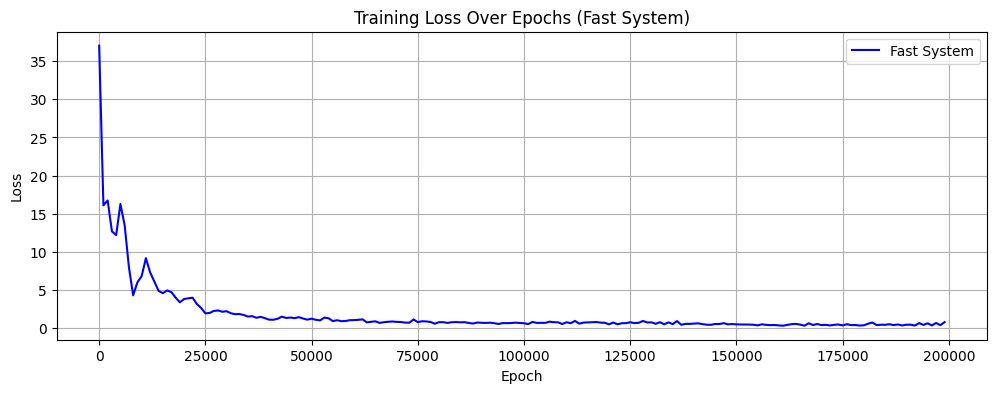

In [3]:
import matplotlib.pyplot as plt

# Plotting training loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(0, epoch_num, 1000), loss_values_fast[:epoch_num//1000], 'b', label='Fast System')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (Fast System)')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation
model.eval()
with torch.no_grad():
    # Predictions for fast system
    x_pred_fast, y_pred_fast, z_pred_fast = model(t_tensor).numpy().T


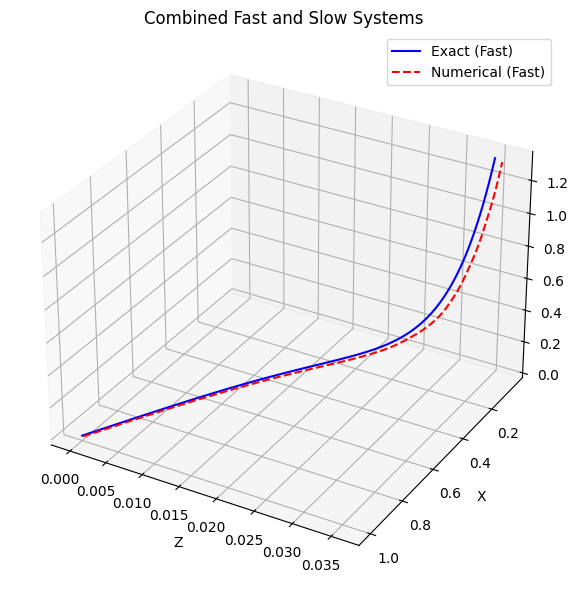

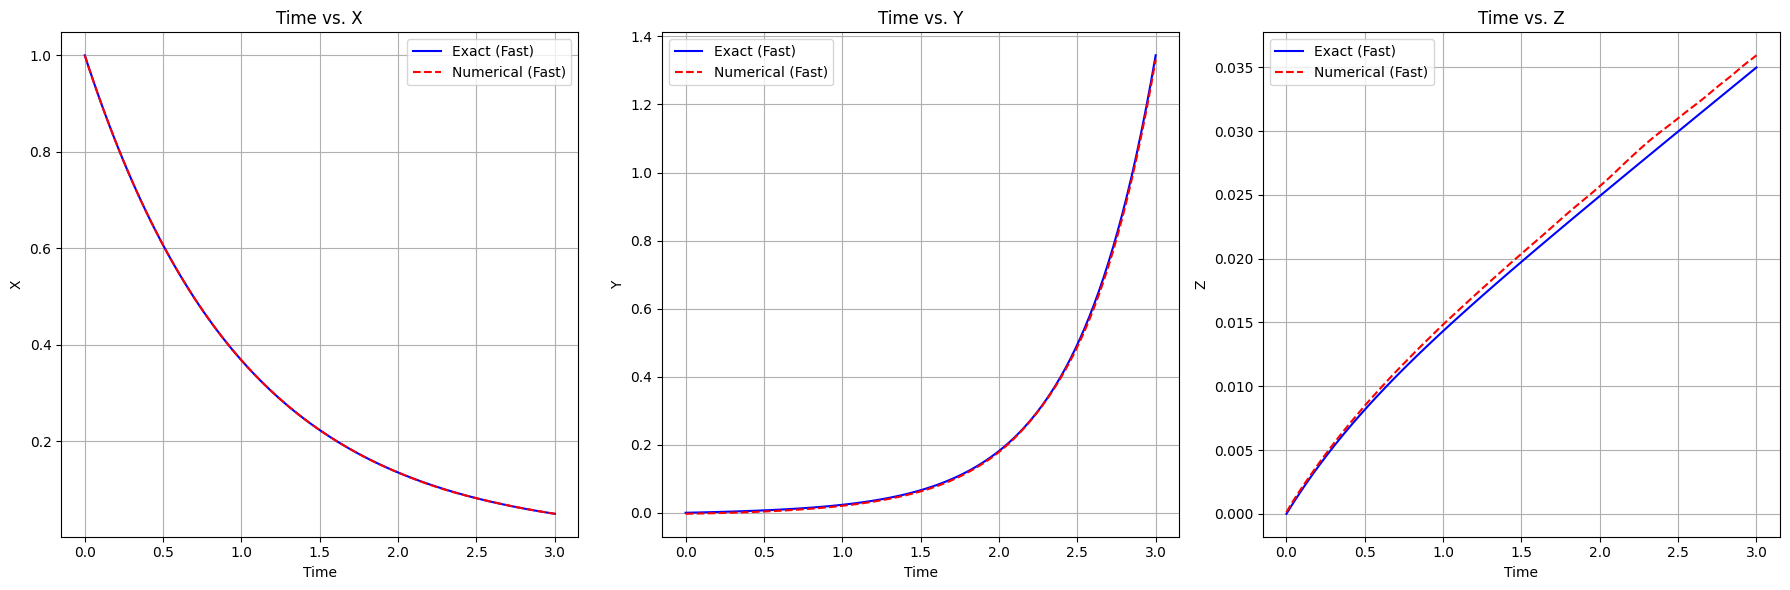

In [4]:
# Plotting the 3D trajectories
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting fast system
ax.plot(z_exact_fast, x_exact_fast, y_exact_fast, 'b-', label='Exact (Fast)')
ax.plot(z_pred_fast, x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')


ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# Plotting time vs. state variables for both fast and slow systems
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting time vs. X for both fast and slow systems
axs[0].plot(t, x_exact_fast, 'b-', label='Exact (Fast)')
axs[0].plot(t, x_pred_fast, 'r--', label='Numerical (Fast)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('X')
axs[0].set_title('Time vs. X')
axs[0].legend()
axs[0].grid(True)

# Plotting time vs. Y for both fast and slow systems
axs[1].plot(t, y_exact_fast, 'b-', label='Exact (Fast)')
axs[1].plot(t, y_pred_fast, 'r--', label='Numerical (Fast)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Y')
axs[1].set_title('Time vs. Y')
axs[1].legend()
axs[1].grid(True)

# Plotting time vs. Z for both fast and slow systems
axs[2].plot(t, z_exact_fast, 'b-', label='Exact (Fast)')
axs[2].plot(t, z_pred_fast, 'r--', label='Numerical (Fast)')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Z')
axs[2].set_title('Time vs. Z')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()



In [14]:
import scipy.optimize as optimize
import numpy as np

# Define the equation
def equation(t):
    return t * np.exp(2 * t) - 1000

# Initial guess
initial_guess = 3

# Solve the equation
t_solution = optimize.fsolve(equation, initial_guess)

print("Solution for t:", t_solution)


Solution for t: [2.91836575]


In [15]:
t0= 2.91836575
0.001 * t0 * np.exp(2 * t0)

1.0000000059641967